# Skeleton plot that shows the arborization of all 6 clusters by Color
Steps in this file:
- Import skeleton, using 2d skeletons segments (kind of buggy)
- Import partition data for full connectome
- Import synapse location data
- Process dataframes so that synapse location and cluster are on the same dataframe
- Assign colors with a dictionary and then map
- Plot segments and synapses with legend

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Loading BokehJS ...

In [3]:
from neuprint import fetch_synapse_connections, SynapseCriteria as SC, merge_neuron_properties, fetch_neurons

In [4]:
pwd

'/Users/rweberla/flybrain-clustering-rhessa'

In [6]:
# Create skeleton for later usage (inspired from Prof G.'s notebook ovi_specs_sandbox.ipynb)
# body Ids of oviINs
ovi_r = 423101189
ovi_l = 485934965
ovis = [ovi_r, ovi_l]

# cretae skeleton for both oviINs
skeletons = []


s = np_client.fetch_skeleton(ovi_r, format='pandas')
s['bodyId'] = ovi_r
s['color'] = bokeh.palettes.Greys[3][1]
skeletons.append(s)

skeletons = pd.concat(skeletons, ignore_index=True)

In [7]:
# Join parent nodes
segments = skeletons.merge(skeletons, left_on=['bodyId', 'link'], right_on=['bodyId', 'rowId'], suffixes=['_child', '_parent'])

In [9]:
ovi_pre_syns = fetch_synapse_connections(None, ovis, SC(primary_only=True))
pre_neurons, _ = fetch_neurons(ovi_pre_syns['bodyId_pre'].unique())
ovi_pre_syns = merge_neuron_properties(pre_neurons, ovi_pre_syns, 'type')

  0%|          | 0/36631 [00:00<?, ?it/s]

In [8]:
pwd

'/Users/rweberla/flybrain-clustering-rhessa'

In [32]:
# import full connectome data and location data
ovi_node_df  = pd.read_csv('/Users/rweberla/Downloads/0-0_98765.txt', header=None, sep=' ', names=['id', "0.0"])

# Import synapse location data for pre-synaptic sites
ovi_pre_syns = pd.read_csv('ovi_pre_syns.csv', index_col=0)


In [33]:
ovi_node_df

,id,0.0
0,1003215282,1
1,1005952640,2
2,1006928515,3
3,1007260806,3
4,1008024276,4
...,...,...
1827,987117151,2
1828,987273073,6
1829,988567837,5
1830,988909130,5


In [34]:
# edit dataframes for easy merging
ovi_clusters = ovi_node_df[['id', '0.0']].copy()
ovi_locs = ovi_pre_syns[['bodyId_pre', 'x_pre', 'y_pre', 'z_pre']].copy()

# merge synapse data onto cluster data
ovi_plotting = ovi_clusters.merge(ovi_locs, left_on='id', right_on='bodyId_pre').drop(columns='bodyId_pre')
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre
0,1003215282,1,24301,16887,21862
1,1005952640,2,21998,15625,18990
2,1005952640,2,22998,15275,23049
3,1005952640,2,23034,15380,23131
4,1006928515,3,22664,14840,19749
...,...,...,...,...,...
18777,987117151,2,17196,30688,23323
18778,987273073,6,19347,27826,15348
18779,988567837,5,23100,27659,23824
18780,988909130,5,19523,31096,21707


In [35]:
# Create color dictionary where each number in column 0.0 is assigned a color
#colors = ['', '#', '#e7cf57', '#ff6a88', '#', '#', '#9fad2b']
color_dict = {1: '#4e90d3', 2: '#9467bd', 3: '#e7cf57', 4: '#ff6a88', 5: '#5cc9ff', 6: '#3a9f82', 7: '#9fad2b'}

# Merge color dictionary onto dataframe
ovi_plotting['color'] = ovi_plotting['0.0'].map(color_dict)
ovi_plotting

,id,0.0,x_pre,y_pre,z_pre,color
0,1003215282,1,24301,16887,21862,#4e90d3
1,1005952640,2,21998,15625,18990,#9467bd
2,1005952640,2,22998,15275,23049,#9467bd
3,1005952640,2,23034,15380,23131,#9467bd
4,1006928515,3,22664,14840,19749,#e7cf57
...,...,...,...,...,...,...
18777,987117151,2,17196,30688,23323,#9467bd
18778,987273073,6,19347,27826,15348,#3a9f82
18779,988567837,5,23100,27659,23824,#5cc9ff
18780,988909130,5,19523,31096,21707,#5cc9ff


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(12897.35, 34229.65, 35193.2, 4542.8)

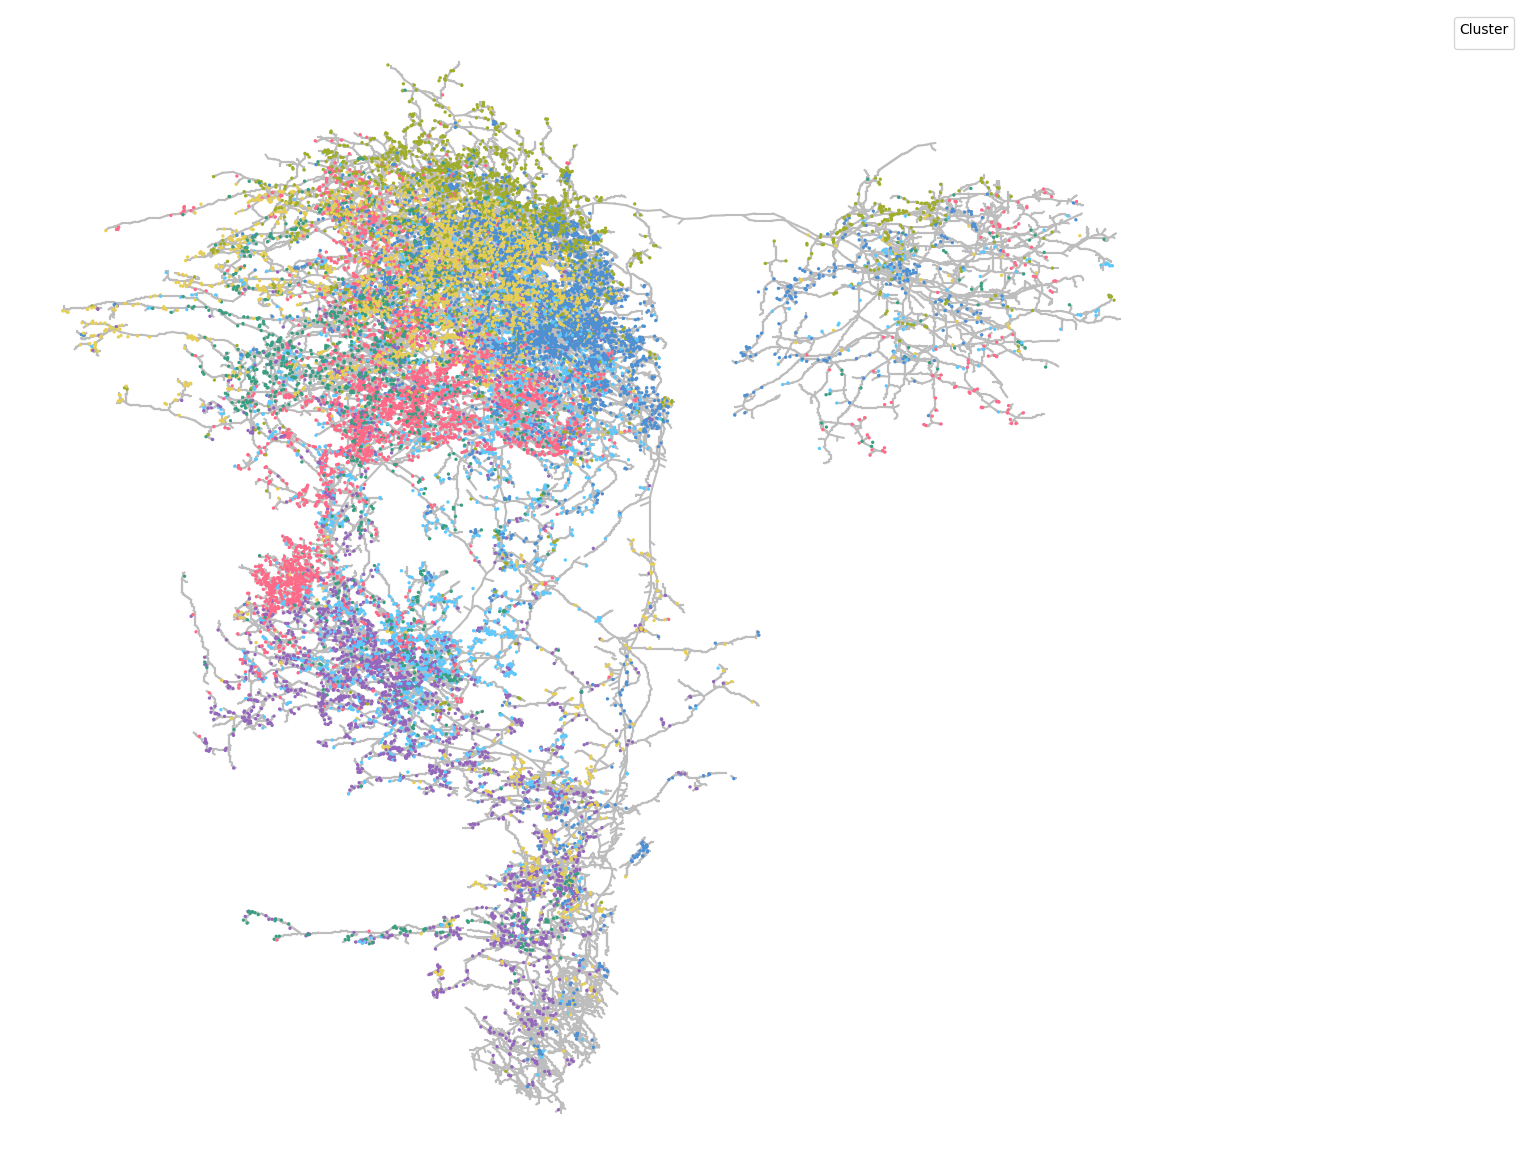

In [41]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# Drop axes 

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting['x_pre'], ovi_plotting['z_pre'], c=ovi_plotting['color'], s=2, zorder=2)
ax.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.3, 1))

plt.axis('off')


## By cluster

In [54]:
# Plot the skeleton plot so it just shows one cluster at a time, should be 7 plots
clusters = [1, 2, 3, 4, 5, 6, 7]
def cluster_nt(df, cluster_list):
    fig, ax = plt.subplots(3,3,figsize=(18, 18))
    for i, cluster in enumerate(cluster_list):
        ax[int(i /3), i % 3].invert_yaxis()  # Flip the y-axis 
        # drop y axis
        ax[int(i / 3), i % 3].set_yticks([])
        ax[int(i / 3), i % 3].set_xticks([])
        df_x = df[df['0.0']==cluster]
        for index, row in segments.iterrows():
            ax[int(i / 3), i % 3].plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], c=row['color_child'], linewidth= 0.5, zorder=1)
        # Plot skeleton 6 times, each time with a different cluster
        ax[int(i / 3), i % 3].scatter(df_x['x_pre'], df_x['z_pre'], color=df_x["color"], s=1, zorder=10)
        # Set title for the subplot
        ax[int(i / 3), i % 3].set_title('Cluster ' + str(cluster))



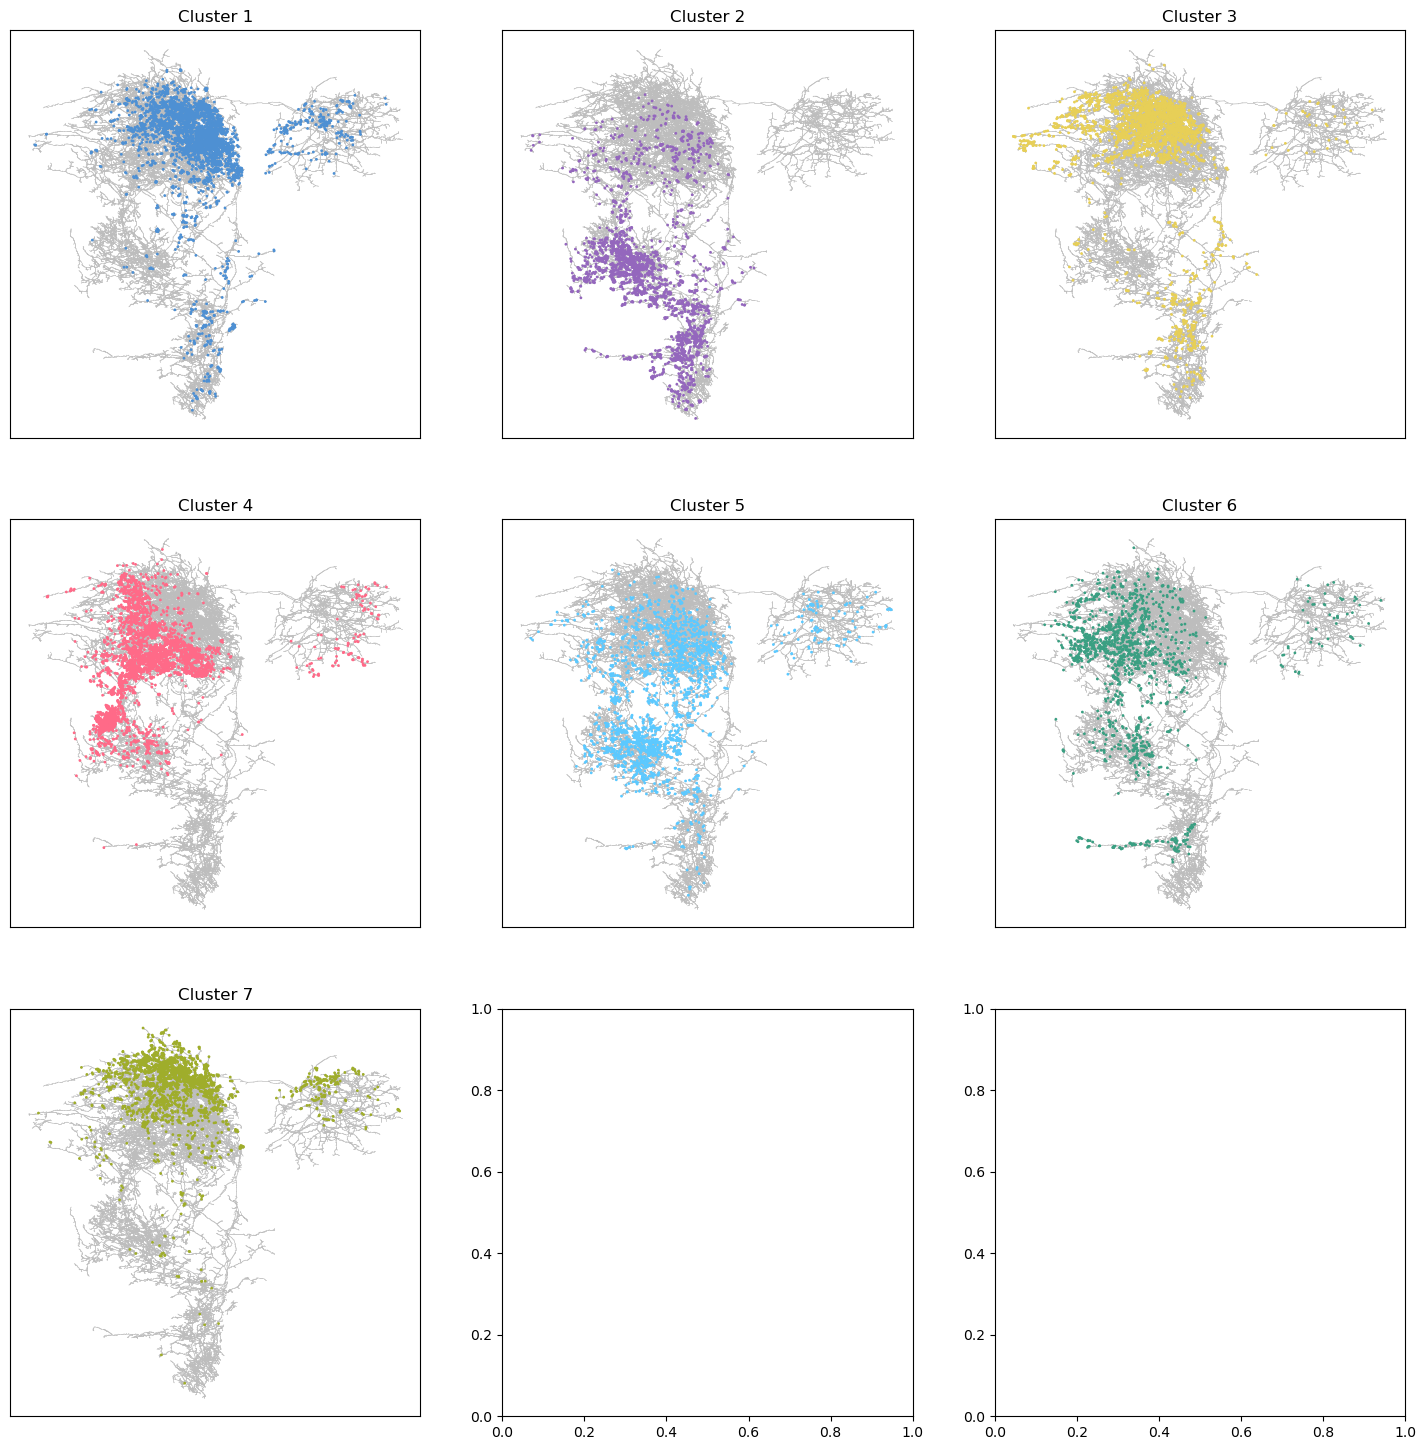

In [55]:
cluster_nt(ovi_plotting, clusters)

# Skeleton plot for celltype breakdown

In [30]:
ovi_cell  = pd.read_csv('oviIN_celltype/oviIN_combined/full/preprocessed-v1.2.1/preprocessed_nodes.csv')
ovi_cell

,Unnamed: 0,celltype,key,0.75,0.05,0.1,0.25,0.5,1.0,0.0
0,0,NaN,1,1,1,1,1,1,1,1
1,1,5-HTPMPD01,2,2,1,1,2,2,2,1
2,2,5-HTPMPV01,3,3,2,2,3,3,3,2
3,3,5-HTPMPV03,4,4,2,3,3,4,4,2
4,4,ALIN3,5,5,3,4,4,5,5,3
...,...,...,...,...,...,...,...,...,...,...
1458,1458,pC1d,1459,439,2,2,70,317,588,2
1459,1459,pC1e,1460,489,2,2,3,349,555,2
1460,1460,v2LN37,1461,511,3,10,17,188,319,3
1461,1461,vpoDN,1462,114,1,1,59,40,92,1


In [31]:
# edit dataframes for easy merging
ovi_type_clusters = ovi_cell[['celltype', '0.0']].copy()
ovi_locs_type = ovi_pre_syns[['type_pre', 'x_pre', 'y_pre', 'z_pre']].copy()

# Drop the NaN value in type clusters
ovi_type_clusters = ovi_type_clusters.dropna()

ovi_type_clusters

,celltype,0.0
1,5-HTPMPD01,1
2,5-HTPMPV01,2
3,5-HTPMPV03,2
4,ALIN3,3
5,AOTU003,4
...,...,...
1458,pC1d,2
1459,pC1e,2
1460,v2LN37,3
1461,vpoDN,1


In [35]:
# Count clusters
ovi_type_clusters['0.0'].unique()

array([1, 2, 3, 4, 5, 6])

In [34]:
# Merge synapse data onto cluster data
ovi_plotting_type = ovi_type_clusters.merge(ovi_locs_type, left_on='celltype', right_on='type_pre').drop(columns='type_pre')
ovi_plotting_type

,celltype,0.0,x_pre,y_pre,z_pre
0,5-HTPMPD01,1,21089,26095,7633
1,5-HTPMPD01,1,19883,31703,9300
2,5-HTPMPD01,1,21957,27833,8998
3,5-HTPMPV01,2,20615,19829,11336
4,5-HTPMPV01,2,19899,20712,12149
...,...,...,...,...,...
25552,vpoDN,1,21269,31699,9148
25553,vpoEN,2,22124,21278,24893
25554,vpoEN,2,22081,21270,24898
25555,vpoEN,2,22190,21296,24976


In [36]:
# Create color dictionary where each number in column 0.0 is assigned a color
color_dict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'pink', 6: 'orange'}

# Merge color dictionary onto dataframe
ovi_plotting_type['color'] = ovi_plotting_type['0.0'].map(color_dict)
ovi_plotting_type

,celltype,0.0,x_pre,y_pre,z_pre,color
0,5-HTPMPD01,1,21089,26095,7633,red
1,5-HTPMPD01,1,19883,31703,9300,red
2,5-HTPMPD01,1,21957,27833,8998,red
3,5-HTPMPV01,2,20615,19829,11336,blue
4,5-HTPMPV01,2,19899,20712,12149,blue
...,...,...,...,...,...,...
25552,vpoDN,1,21269,31699,9148,red
25553,vpoEN,2,22124,21278,24893,blue
25554,vpoEN,2,22081,21270,24898,blue
25555,vpoEN,2,22190,21296,24976,blue


Text(0.5, 1.0, 'OviINs with cell types clustered')

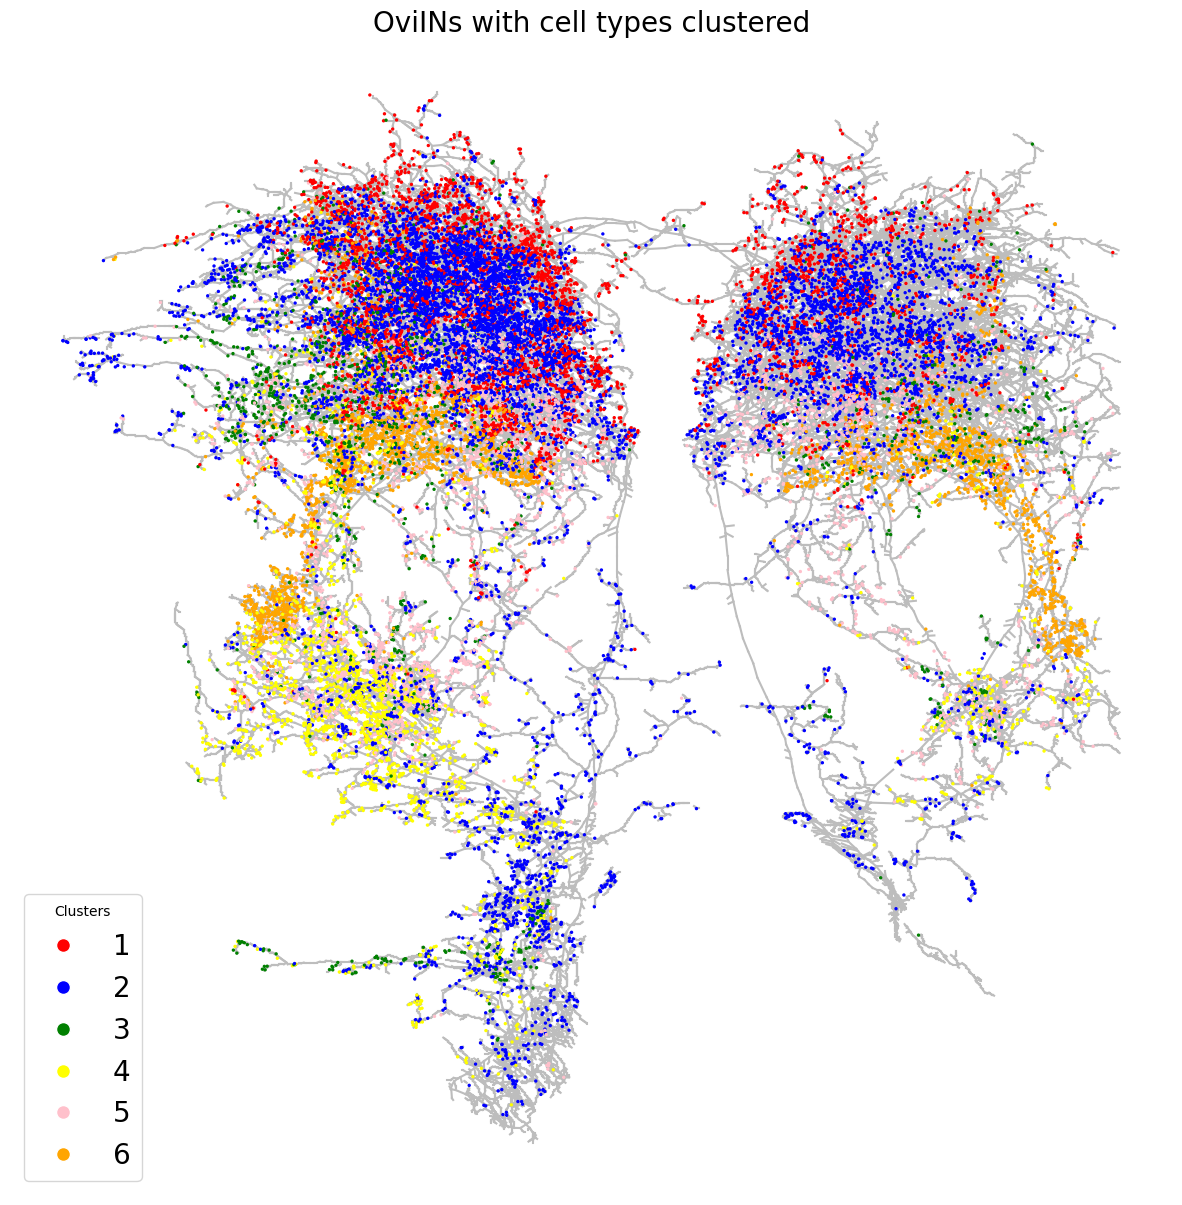

In [45]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# Drop axes 

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting_type['x_pre'], ovi_plotting_type['z_pre'], c=ovi_plotting_type['color'], s=2, zorder=2)
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='2'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='3'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='4'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='5'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='6')], title='Clusters',fontsize="20", loc='lower left')
plt.axis('off')
plt.title('OviINs with cell types clustered', fontsize=20)


In [44]:
ovi_plotting_type[ovi_plotting_type['celltype']=='FS1A']


,celltype,0.0,x_pre,y_pre,z_pre,color
3766,FS1A,6,19832,26702,15404,orange
3767,FS1A,6,20845,26499,15613,orange
3768,FS1A,6,20373,26632,15491,orange
3769,FS1A,6,20897,26459,15609,orange
3770,FS1A,6,19506,26715,15912,orange
...,...,...,...,...,...,...
5350,FS1A,6,31949,26913,15156,orange
5351,FS1A,6,31442,26585,15559,orange
5352,FS1A,6,30865,27005,14987,orange
5353,FS1A,6,31281,26775,16116,orange
